##### Copyright 2023 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Visualizing embeddings with t-SNE


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://developers.generativeai.google/examples/clustering_with_embeddings"><img src="https://developers.generativeai.google/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Generative AI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/examples/clustering_with_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/examples/clustering_with_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to visualize and perform clustering with the embeddings from the PaLM API. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html){:.external} and cluster that subset using the KMeans algorithm.

For more information on getting started with embeddings generated from the PaLM API, check out the [quickstart](../tutorials/embeddings_quickstart.ipynb).

## Setup

First, download and install the PaLM API Python library.

In [2]:
!pip install -q google-generativeai

In [3]:
import google.generativeai as palm

import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Get an API Key

To get started, you'll need to [create an API key](https://developers.generativeai.google/tutorials/setup).

In [4]:
palm.configure(api_key='YOUR_API_KEY')

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

**Note**: At this time, the PaLM API is [only available in certain regions](https://developers.generativeai.google/available_regions).

In [5]:
models = [m for m in palm.list_models() if 'embedText' in m.supported_generation_methods]

model = models[0]

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the training subset.

In [6]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [7]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [8]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

In [9]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [10]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,Competing standard\nNntp-Posting-Host: mizzou...,11,sci.crypt
1,1651,"Subject: Re: Don't fight Clipper Chip, subvert...",11,sci.crypt
2,1652,"Re: Pgp, PEM, and RFC's \nNntp-Posting-Host: ...",11,sci.crypt
3,1653,THE CLIPPER CHIP: A TECHNICAL SUMMARY\nDistrib...,11,sci.crypt
4,1654,"Re: Pgp, PEM, and RFC's \nOrganization: Oce G...",11,sci.crypt
...,...,...,...,...
595,2245,Re: Jemison on Star Trek \nOrganization: Expr...,14,sci.space
596,2246,Re: Alaska Pipeline and Space Station!\nOrgan...,14,sci.space
597,2247,"Space Station Redesign, JSC Alternative #4\nOr...",14,sci.space
598,2248,Re: Solar Sail Data\nOrganization: Sun Micros...,14,sci.space


In [11]:
df_train['Class Name'].value_counts()

Class Name
sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: count, dtype: int64

## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the PaLM API.

In [12]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    return palm.generate_embeddings(model=model, text=text)['embedding']

  return embed_fn

def create_embeddings(model, df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(model, df_train)

  0%|          | 0/600 [00:00<?, ?it/s]

## Dimensionality reduction

The length of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [13]:
len(df_train['Embeddings'][0])

768

In [14]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.


In [15]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [16]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-1.212522,-22.677013,sci.crypt
1,3.995803,-11.590203,sci.crypt
2,9.159574,-10.091983,sci.crypt
3,-5.450058,-15.795723,sci.crypt
4,7.922492,-10.505751,sci.crypt
...,...,...,...
595,0.272435,35.359333,sci.space
596,4.217656,24.452595,sci.space
597,4.366329,20.885956,sci.space
598,-1.971566,24.719038,sci.space


(-39.6663013458252, 42.38134346008301, -35.120894813537596, 38.98466053009033)

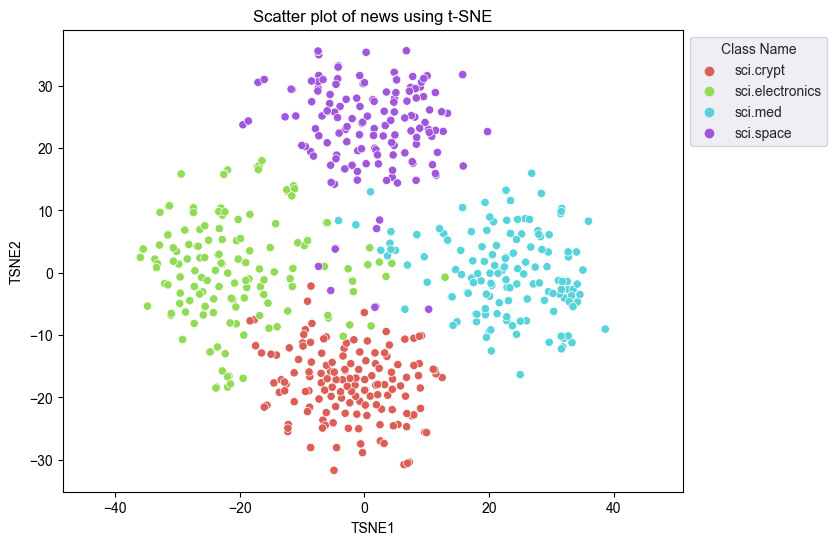

In [17]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## Compare results to KMeans

[KMeans clustering](https://developers.google.com/machine-learning/glossary#k-means){:.external} is a popular clustering algorithm and used often for unsupervised learning. It iteratively determines the best k center points, and assigns each example to the closest centroid. Input the embeddings directly into the KMeans algorithm to compare the visualization of the embeddings to the performance of a machine learning algorithm.

In [18]:
# Apply KMeans
kmeans_model = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)

In [19]:
df_tsne['Cluster'] = labels
df_tsne

,TSNE1,TSNE2,Class Name,Cluster
0,-1.212522,-22.677013,sci.crypt,0
1,3.995803,-11.590203,sci.crypt,0
2,9.159574,-10.091983,sci.crypt,0
3,-5.450058,-15.795723,sci.crypt,0
4,7.922492,-10.505751,sci.crypt,0
...,...,...,...,...
595,0.272435,35.359333,sci.space,1
596,4.217656,24.452595,sci.space,1
597,4.366329,20.885956,sci.space,1
598,-1.971566,24.719038,sci.space,1


(-39.6663013458252, 42.38134346008301, -35.120894813537596, 38.98466053009033)

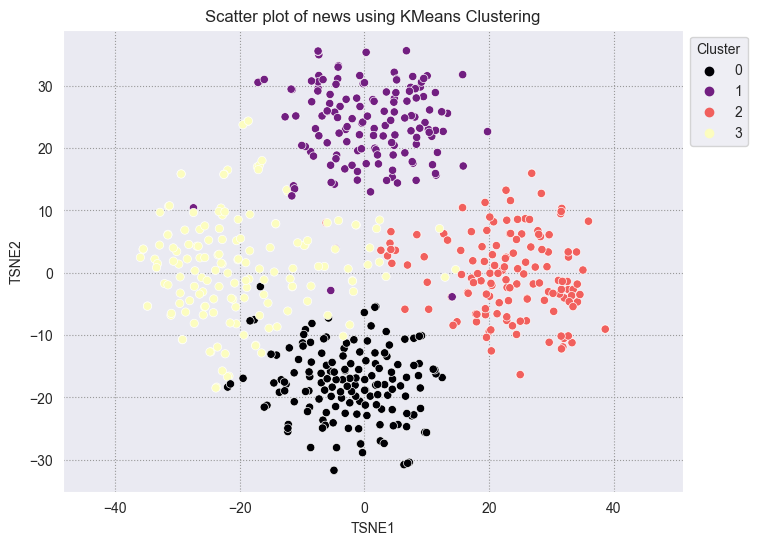

In [26]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [21]:
def get_majority_cluster_per_group(df_tsne_cluster, class_names):
  class_clusters = dict()
  for c in class_names:
    # Get rows of dataframe that are equal to c
    rows = df_tsne_cluster.loc[df_tsne_cluster['Class Name'] == c]
    # Get majority value in Cluster column of the rows selected
    cluster = rows.Cluster.mode().values[0]
    # Populate mapping dictionary
    class_clusters[c] = cluster
  return class_clusters

In [22]:
classes = df_tsne['Class Name'].unique()
class_clusters = get_majority_cluster_per_group(df_tsne, classes)
class_clusters

{'sci.crypt': 0, 'sci.electronics': 3, 'sci.med': 2, 'sci.space': 1}

Get the majority of clusters per group, and see how many of the actual members of that group are in that cluster.

In [23]:
# Convert the Cluster column to use the class name
class_by_id = {v: k for k, v in class_clusters.items()}
df_tsne['Predicted'] = df_tsne['Cluster'].map(class_by_id.__getitem__)

# Filter to the correctly matched rows
correct = df_tsne[df_tsne['Class Name'] == df_tsne['Predicted']]

# Summarise, as a percentage
acc = correct['Class Name'].value_counts() / SAMPLE_SIZE
acc

Class Name
sci.crypt          0.966667
sci.med            0.940000
sci.space          0.933333
sci.electronics    0.920000
Name: count, dtype: float64

In [24]:
# Get predicted values by name
df_tsne['Predicted'] = ''
for idx, rows in df_tsne.iterrows():
  cluster = rows['Cluster']
  # Get key from mapping based on cluster value
  key = list(class_clusters.keys())[list(class_clusters.values()).index(cluster)]
  df_tsne.at[idx, 'Predicted'] = key

df_tsne

,TSNE1,TSNE2,Class Name,Cluster,Predicted
0,-1.212522,-22.677013,sci.crypt,0,sci.crypt
1,3.995803,-11.590203,sci.crypt,0,sci.crypt
2,9.159574,-10.091983,sci.crypt,0,sci.crypt
3,-5.450058,-15.795723,sci.crypt,0,sci.crypt
4,7.922492,-10.505751,sci.crypt,0,sci.crypt
...,...,...,...,...,...
595,0.272435,35.359333,sci.space,1,sci.space
596,4.217656,24.452595,sci.space,1,sci.space
597,4.366329,20.885956,sci.space,1,sci.space
598,-1.971566,24.719038,sci.space,1,sci.space


To better visualize the performance of the KMeans applied to your data, you can use a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. You will need the actual values and the predicted values, which you have gathered in the dataframe above.

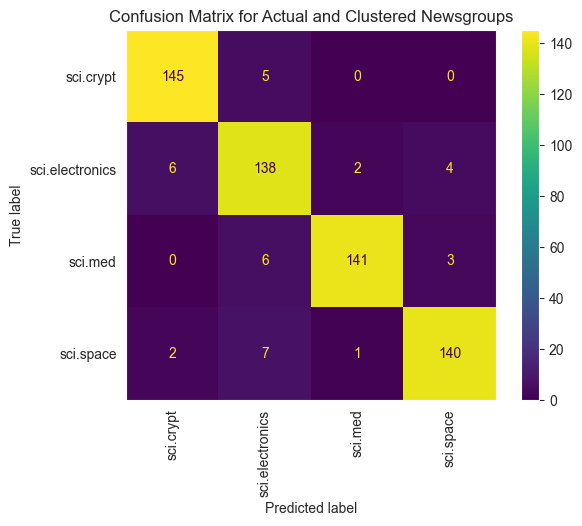

In [25]:
cm = confusion_matrix(df_tsne['Class Name'].to_list(), df_tsne['Predicted'].to_list())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for Actual and Clustered Newsgroups');
plt.grid(False)

## Next steps

You've now created your own visualization of embeddings with clustering! Try using your own textual data to visualize them as embeddings. You can perform dimensionality reduction in order to complete the visualization step. Note that TSNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis){:.external}.

There are other clustering algorithms outside of KMeans as well, such as [density-based spatial clustering (DBSCAN)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html){:.external}.

To learn more about how you can use the embeddings, check out the examples available. To learn how to create them from scratch, see TensorFlow's [Word Embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial. To learn how to use other services in the PaLM API, visit the various quickstart guides:

* [Chat quickstart](../tutorials/chat_quickstart.ipynb)

* [Text generation quickstart](../tutorials/text_quickstart.ipynb)